In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from visualization import jitter_plot, utils

#### Helper functions

This one generates a number of counts for $n$ samples according to a Poisson distribution with parameter $l$.

In [2]:
def counts(l, n):
    samples = np.random.poisson(l,n)
    return pd.DataFrame(np.array([samples,samples]).T).groupby(0).count().to_records()

### Jitter plot

In [3]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,500) ]
data = pd.DataFrame(data)

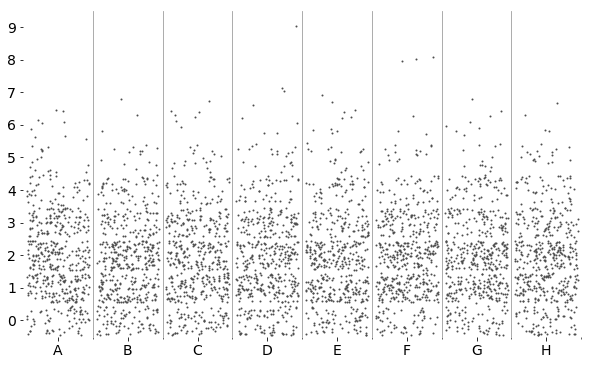

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

jitter_plot(ax, data, jitter=True, markersize=1)

### "Regular" jitter plot

In [5]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,30) ]
data = pd.DataFrame(data)

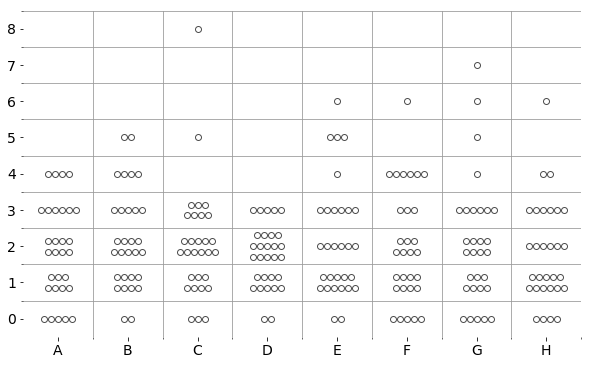

In [6]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

jitter_plot(ax, data, jitter=False, n_max=6, dy=0.3, show_rows=True)

### A more complex example

This one reverts the $y$ axis and uses color to highlight bands and to mark the last and median point.

In [7]:
data = []
for l in 'ABCDEFGH':
    data += [ (l,i,n) for i,n in counts(2,30) ]
data = pd.DataFrame(data, columns=['label','value','count'])

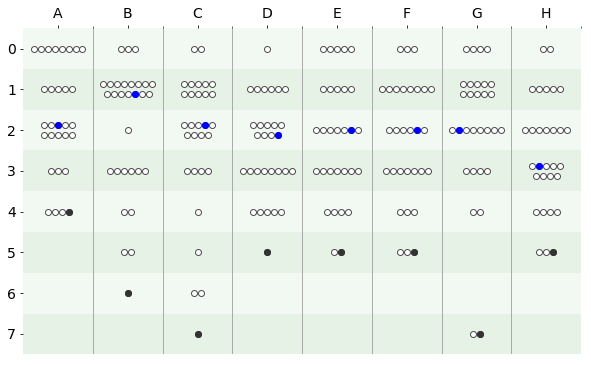

In [8]:
def last(N):
    return N-1

def median(N):
    return N//2

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
utils.despine(ax)

max_n = data['value'].max()

ax.xaxis.tick_top()
for i in range(max_n+1):
    color, alpha = ('green', 0.1) if i%2 else ('green', 0.05)
    ax.axhspan(i-0.5,i+0.5,facecolor=color, alpha=alpha)

jitter_plot(ax, data, jitter=False, n_max=8,
            highlights=[(median, 'blue'),
                        (last, '0.2')])

ax.invert_yaxis()